In [43]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')

from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.model_selection import cross_val_score,GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor


plt.rcParams['axes.unicode_minus'] = False

In [44]:
train=pd.read_csv("train.csv")
test=pd.read_csv("test.csv")
submission=pd.read_csv("sample_submission.csv")

In [45]:
train.head()

,id,Species,Island,Clutch Completion,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Body Mass (g)
0,0,Gentoo penguin (Pygoscelis papua),Biscoe,Yes,50.0,15.3,220,MALE,8.30515,-25.19017,5550
1,1,Chinstrap penguin (Pygoscelis antarctica),Dream,No,49.5,19.0,200,MALE,9.63074,-24.34684,3800
2,2,Gentoo penguin (Pygoscelis papua),Biscoe,Yes,45.1,14.4,210,FEMALE,8.51951,-27.01854,4400
3,3,Gentoo penguin (Pygoscelis papua),Biscoe,Yes,44.5,14.7,214,FEMALE,8.20106,-26.16524,4850
4,4,Gentoo penguin (Pygoscelis papua),Biscoe,No,49.6,16.0,225,MALE,8.38324,-26.84272,5700


In [46]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114 entries, 0 to 113
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   114 non-null    int64  
 1   Species              114 non-null    object 
 2   Island               114 non-null    object 
 3   Clutch Completion    114 non-null    object 
 4   Culmen Length (mm)   114 non-null    float64
 5   Culmen Depth (mm)    114 non-null    float64
 6   Flipper Length (mm)  114 non-null    int64  
 7   Sex                  111 non-null    object 
 8   Delta 15 N (o/oo)    111 non-null    float64
 9   Delta 13 C (o/oo)    111 non-null    float64
 10  Body Mass (g)        114 non-null    int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 9.9+ KB


<li>id : 샘플 아이디</li>
<li>Species: 펭귄의 종을 나타내는 문자열</li>
<li>Island : 샘플들이 수집된 Palmer Station 근처 섬 이름</li>
<li>Clutch Completion : 관찰된 펭귄 둥지의 알이 2개인 경우 Full Clutch이며 Yes로 표기</li>
<li>Culmen Length (mm) : 펭귄 옆모습 기준 부리의 가로 길이</li>
<li>Culmen Depth (mm) : 펭귄 옆모습 기준 부리의 세로 길이</li>
<li>Flipper Length (mm) : 펭귄의 팔(날개) 길이</li>
<li>Sex : 펭귄의 성별</li>
<li>Delta 15 N (o/oo)  : 토양에 따라 변화하는 안정 동위원소 15N:14N의 비율</li>
<li>Delta 13 C (o/oo) : 먹이에 따라 변화하는 안정 동위원소 13C:12C의 비율</li>
<li>Body Mass (g): 펭귄의 몸무게를 나타내는 숫자 (g)</li>

<AxesSubplot:>

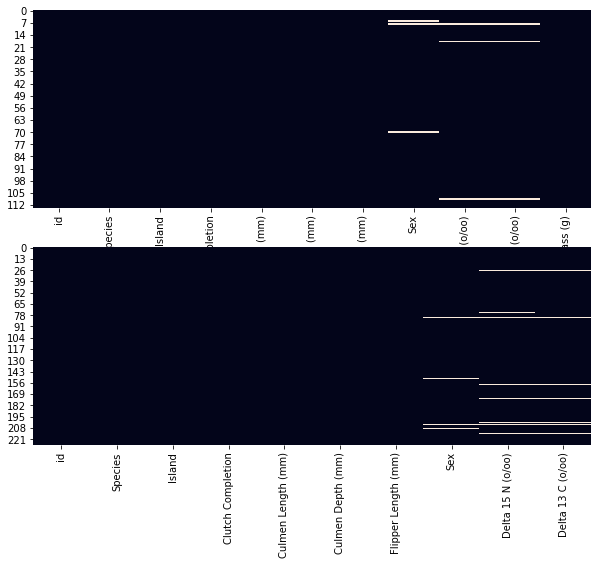

In [47]:
plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
sns.heatmap(train.isna(),cbar=False)
plt.subplot(2,1,2)
sns.heatmap(test.isna(),cbar=False)

In [50]:
print('Sex의 결측치 : \n',train[train['Sex'].isna()])
print('Delta 15 N (o/oo)의 결측치 : \n',train[train['Delta 15 N (o/oo)'].isna()])
print('Delta 13 C (o/oo)의 결측치 : \n',train[train['Delta 13 C (o/oo)'].isna()])

Sex의 결측치 : 
     id                              Species     Island Clutch Completion  \
6    6  Adelie Penguin (Pygoscelis adeliae)  Torgersen               Yes   
8    8  Adelie Penguin (Pygoscelis adeliae)  Torgersen               Yes   
70  70    Gentoo penguin (Pygoscelis papua)     Biscoe               Yes   

    Culmen Length (mm)  Culmen Depth (mm)  Flipper Length (mm)  Sex  \
6                 42.0               20.2                  190  NaN   
8                 34.1               18.1                  193  NaN   
70                46.2               14.4                  214  NaN   

    Delta 15 N (o/oo)  Delta 13 C (o/oo)  Body Mass (g)  
6             9.13362          -25.09368           4250  
8                 NaN                NaN           3475  
70            8.24253          -26.81540           4650  
Delta 15 N (o/oo)의 결측치 : 
       id                              Species     Island Clutch Completion  \
8      8  Adelie Penguin (Pygoscelis adeliae)  Torgersen    

## Exploratory Data Analysis

In [7]:
print(train['Species'].unique())
print(train['Island'].unique())

['Gentoo penguin (Pygoscelis papua)'
 'Chinstrap penguin (Pygoscelis antarctica)'
 'Adelie Penguin (Pygoscelis adeliae)']
['Biscoe' 'Dream' 'Torgersen']


<AxesSubplot:xlabel='Body Mass (g)', ylabel='Density'>

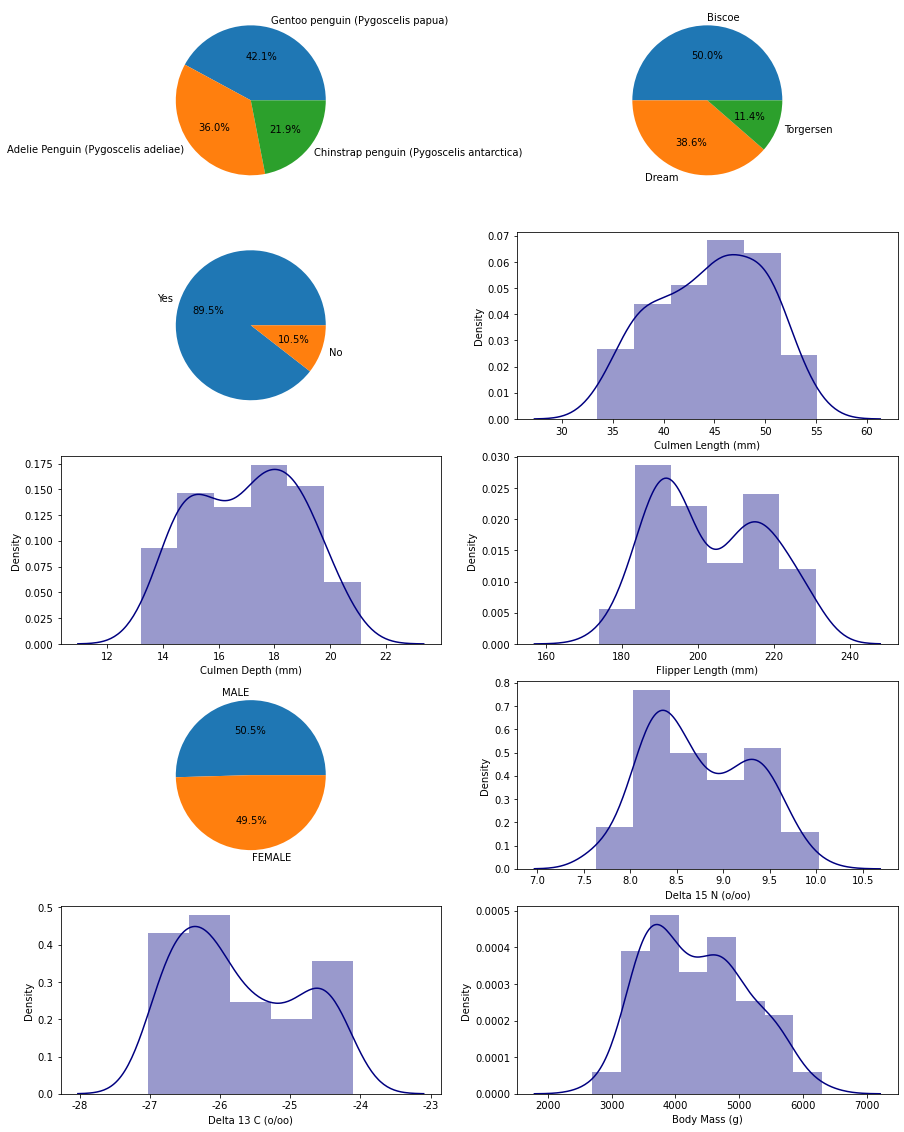

In [8]:
plt.figure(figsize=(15,20))
plt.subplot(5,2,1)
plt.pie(train['Species'].value_counts(),
        labels=[train['Species'].value_counts().index[0],train['Species'].value_counts().index[1],train['Species'].value_counts().index[2]],
        autopct="%.1f%%")
plt.subplot(5,2,2)
plt.pie(train['Island'].value_counts(),
        labels=[train['Island'].value_counts().index[0],train['Island'].value_counts().index[1],train['Island'].value_counts().index[2]],
        autopct="%.1f%%")
plt.subplot(5,2,3)
plt.pie(train['Clutch Completion'].value_counts(),
        labels=[train['Clutch Completion'].value_counts().index[0],train['Clutch Completion'].value_counts().index[1]],
        autopct="%.1f%%")
plt.subplot(5,2,4)
sns.distplot(train['Culmen Length (mm)'],color='navy')
plt.subplot(5,2,5)
sns.distplot(train['Culmen Depth (mm)'],color='navy')
plt.subplot(5,2,6)
sns.distplot(train['Flipper Length (mm)'],color='navy')
plt.subplot(5,2,7)
plt.pie(train['Sex'].value_counts(),
        labels=[train['Sex'].value_counts().index[0],train['Sex'].value_counts().index[1]],
        autopct="%.1f%%")
plt.subplot(5,2,8)
sns.distplot(train['Delta 15 N (o/oo)'],color='navy')
plt.subplot(5,2,9)
sns.distplot(train['Delta 13 C (o/oo)'],color='navy')
plt.subplot(5,2,10)
sns.distplot(train['Body Mass (g)'],color='navy')


In [51]:
le=LabelEncoder()
train['Species']=le.fit_transform(train['Species'])
train['Island']=le.fit_transform(train['Island'])
train=pd.get_dummies(train)


test['Species']=le.fit_transform(test['Species'])
test['Island']=le.fit_transform(test['Island'])
test=pd.get_dummies(test)

In [53]:
train.head()

,id,Species,Island,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Delta 15 N (o/oo),Delta 13 C (o/oo),Body Mass (g),Clutch Completion_No,Clutch Completion_Yes,Sex_FEMALE,Sex_MALE
0,0,2,0,50.0,15.3,220,8.30515,-25.19017,5550,0,1,0,1
1,1,1,1,49.5,19.0,200,9.63074,-24.34684,3800,1,0,0,1
2,2,2,0,45.1,14.4,210,8.51951,-27.01854,4400,0,1,1,0
3,3,2,0,44.5,14.7,214,8.20106,-26.16524,4850,0,1,1,0
4,4,2,0,49.6,16.0,225,8.38324,-26.84272,5700,1,0,0,1


<AxesSubplot:>

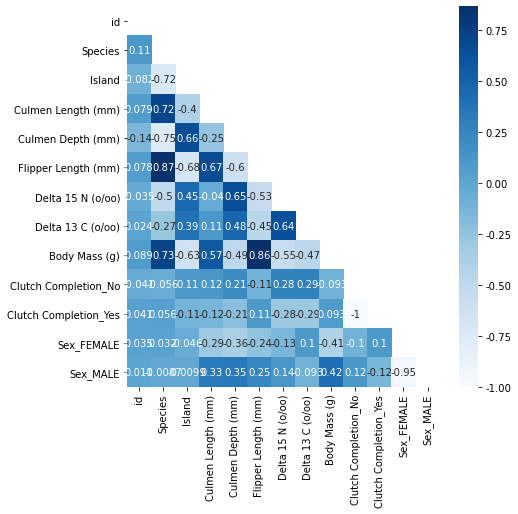

In [11]:
mask=np.zeros_like(train.corr(),dtype=np.bool)
mask[np.triu_indices_from(mask)]=True

plt.figure(figsize=(7,7))
sns.heatmap(train.corr(),annot=True,mask=mask,cmap='Blues')

변수 간의 상관관계가 존재한다.

<AxesSubplot:xlabel='Delta 15 N (o/oo)', ylabel='Delta 13 C (o/oo)'>

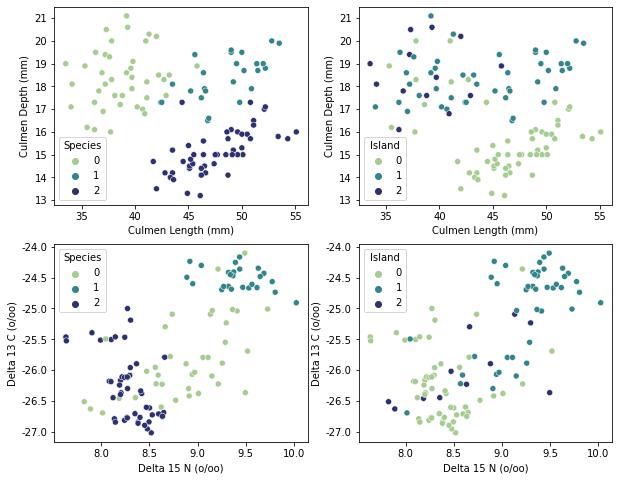

In [12]:
plt.figure(figsize=(10,8))
plt.subplot(2,2,1)
sns.scatterplot(data=train,x='Culmen Length (mm)',y='Culmen Depth (mm)',hue='Species',palette='crest')
plt.subplot(2,2,2)
sns.scatterplot(data=train,x='Culmen Length (mm)',y='Culmen Depth (mm)',hue='Island',palette='crest')
plt.subplot(2,2,3)
sns.scatterplot(data=train,x='Delta 15 N (o/oo)',y='Delta 13 C (o/oo)',hue='Species',palette='crest')
plt.subplot(2,2,4)
sns.scatterplot(data=train,x='Delta 15 N (o/oo)',y='Delta 13 C (o/oo)',hue='Island',palette='crest')

<AxesSubplot:xlabel='Species', ylabel='Flipper Length (mm)'>

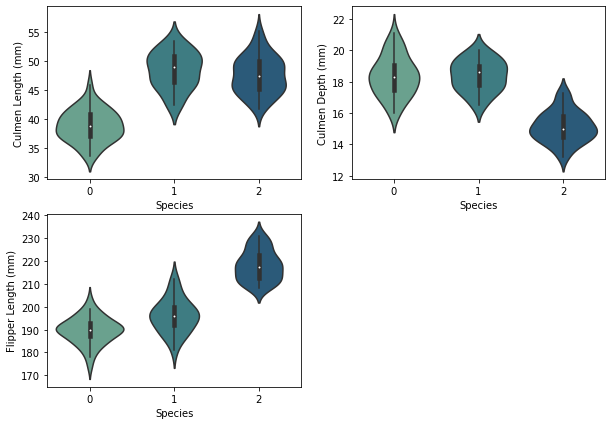

In [13]:
plt.figure(figsize=(10,7))
plt.subplot(2,2,1)
sns.violinplot(data=train,x='Species',y='Culmen Length (mm)',palette='crest')
plt.subplot(2,2,2)
sns.violinplot(data=train,x='Species',y='Culmen Depth (mm)',palette='crest')
plt.subplot(2,2,3)
sns.violinplot(data=train,x='Species',y='Flipper Length (mm)',palette='crest')

## Data Preprocessing

In [14]:
print('Delta 15 N (o/oo)\n',train['Delta 15 N (o/oo)'].describe())
print('------------------------------------------')
print('Delta 13 C (o/oo)\n',train['Delta 13 C (o/oo)'].describe())

Delta 15 N (o/oo)
 count    111.000000
mean       8.737634
std        0.567698
min        7.632200
25%        8.272585
50%        8.632590
75%        9.264635
max       10.025440
Name: Delta 15 N (o/oo), dtype: float64
------------------------------------------
Delta 13 C (o/oo)
 count    111.000000
mean     -25.723051
std        0.859786
min      -27.018540
25%      -26.434025
50%      -25.955410
75%      -25.005945
max      -24.102550
Name: Delta 13 C (o/oo), dtype: float64


In [54]:
train['Delta 15 N (o/oo)'].fillna(train['Delta 15 N (o/oo)'].median(),inplace=True)
train['Delta 13 C (o/oo)'].fillna(train['Delta 13 C (o/oo)'].median(),inplace=True)
train.fillna(0,inplace=True)

test['Delta 15 N (o/oo)'].fillna(test['Delta 15 N (o/oo)'].median(),inplace=True)
test['Delta 13 C (o/oo)'].fillna(test['Delta 13 C (o/oo)'].median(),inplace=True)
test.fillna(0,inplace=True)

In [55]:
ss=StandardScaler()
dtr_train=train.copy()
dtr_test=test.copy()

dtr_train=ss.fit_transform(dtr_train)
dtr_test=ss.fit_transform(dtr_test)

dtr_train=pd.DataFrame(dtr_train,columns=[train.columns])

In [57]:
dtr_train.head()

,id,Species,Island,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Delta 15 N (o/oo),Delta 13 C (o/oo),Body Mass (g),Clutch Completion_No,Clutch Completion_Yes,Sex_FEMALE,Sex_MALE
0,-1.716923,1.064848,-0.900401,1.016685,-0.887255,1.161653,-0.770241,0.637574,1.570219,-0.342997,0.342997,-0.965507,1.017700
1,-1.686535,-0.069663,0.565966,0.922318,1.027037,-0.209242,1.605781,1.635141,-0.678184,2.915476,-2.915476,-0.965507,1.017700
2,-1.656147,1.064848,-0.900401,0.091884,-1.352893,0.476205,-0.386016,-1.525190,0.092697,-0.342997,0.342997,1.035725,-0.982607
3,-1.625759,1.064848,-0.900401,-0.021357,-1.197680,0.750384,-0.956814,-0.515828,0.670858,-0.342997,0.342997,1.035725,-0.982607
4,-1.595371,1.064848,-0.900401,0.941191,-0.525091,1.504376,-0.630270,-1.317214,1.762940,2.915476,-2.915476,-0.965507,1.017700


## Model Selection

In [58]:
dtr=DecisionTreeRegressor()
rfr=RandomForestRegressor()
lgbr=LGBMRegressor()

In [59]:
train.columns

Index(['id', 'Species', 'Island', 'Culmen Length (mm)', 'Culmen Depth (mm)',
       'Flipper Length (mm)', 'Delta 15 N (o/oo)', 'Delta 13 C (o/oo)',
       'Body Mass (g)', 'Clutch Completion_No', 'Clutch Completion_Yes',
       'Sex_FEMALE', 'Sex_MALE'],
      dtype='object')

In [60]:
features=['Species', 'Island', 'Culmen Length (mm)', 'Culmen Depth (mm)',
       'Flipper Length (mm)', 'Delta 15 N (o/oo)', 'Delta 13 C (o/oo)',
       'Clutch Completion_No', 'Clutch Completion_Yes', 'Sex_FEMALE',
       'Sex_MALE']
target='Body Mass (g)'

X_train=train[features]
X_test=test[features]
Y_train=train[target]

X_train_scaled=dtr_train[features]
Y_train_scaled=dtr_train[target]

In [61]:
print('Decision Tree Regressor : ',round(cross_val_score(dtr,X_train,Y_train,cv=5).mean(),4))
print('Decision Tree Regressor Scaled : ',round(cross_val_score(dtr,X_train_scaled,Y_train_scaled,cv=5).mean(),4))
print('Random Forest Regressor : ',round(cross_val_score(rfr,X_train,Y_train,cv=5).mean(),4))
print('LightGBM Regressor : ',round(cross_val_score(lgbr,X_train,Y_train,cv=5).mean(),4))

Decision Tree Regressor :  0.6503
Decision Tree Regressor Scaled :  0.6412
Random Forest Regressor :  0.7844
LightGBM Regressor :  0.8062


In [62]:
dtr.fit(X_train,Y_train)
result_dtr=dtr.predict(X_test)

rfr.fit(X_train,Y_train)
result_rfr=rfr.predict(X_test)

lgbr.fit(X_train,Y_train)
result_lgbr=lgbr.predict(X_test)

lgbr_submission=submission.copy()
lgbr_submission['Body Mass (g)']=0.3*result_dtr+0.33*result_rfr+0.37*result_lgbr

In [63]:
lgbr_submission.to_csv("submission.csv",index=False)

## Hyperparameter Tuning

In [ ]:
params = {
    'boosting_type' : ['gbdt','dart'],
    'max_depth' : [5,6,7],
    'n_estimators': [100, 200,300,400],
    'learning_rate': [0.001, 0.003,0.01,0.03],
    'reg_alpha' : [0,0.01,0.03],
    'reg_lambda' : [0,0.01,0.03,0.1]
}

gs = GridSearchCV(lgbr, param_grid=params, cv=5, refit=True)
gs.fit(X_train, Y_train)

print('best parameters : ', gs.best_params_)
print('best score : ', gs.best_score_)

In [ ]:
lgbr_1=LGBMRegressor(learning_rate=0.01,max_depth=5,n_estimators=,reg_lambda=0.01)

In [ ]:
lgbr_1.fit(X_train,Y_train)
result_tuned1=lgbr_1.predict(X_test)
submission1=submission.copy()
submission1['Body Mass (g)']=result_tuned1
submission1.to_csv("submission_2.csv",index=False)